### 说明（EfficientNetB7）
#### kaggle 得分：0.843
#### 以前的问题可能出在predictions部分（已改进）本例只训练了5个epochs
#### 未使用：rescale=1./255

In [ ]:
import numpy as np
import pandas as pd
import json
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Input, Model
from keras.layers import Dense, Dropout, Flatten, add
import keras

In [3]:
from keras.utils import to_categorical, Sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop,Adam

In [4]:
BASE_DIR = "../input/cassava-leaf-disease-classification/"

os.listdir(BASE_DIR)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [5]:
train_data = pd.read_csv(BASE_DIR+'train.csv')
samp_subm = pd.read_csv(BASE_DIR+'sample_submission.csv')

print(train_data)

             image_id  label
0      1000015157.jpg      0
1      1000201771.jpg      3
2       100042118.jpg      1
3      1000723321.jpg      1
4      1000812911.jpg      3
...               ...    ...
21392   999068805.jpg      3
21393   999329392.jpg      3
21394   999474432.jpg      1
21395   999616605.jpg      4
21396   999998473.jpg      4

[21397 rows x 2 columns]


In [6]:
print('number of train data:', len(train_data))
print('number of train images:', len(os.listdir(BASE_DIR+'train_images/')))
print('number of test images:', len(os.listdir(BASE_DIR+'test_images/')))

number of train data: 21397
number of train images: 21397
number of test images: 1


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
train_df['label'] = train_df['label'].astype(str)

batch_size=16
input_size = (224, 224)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split = 0.1,
    rotation_range=360,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    #channel_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None,
    preprocessing_function=None,
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(BASE_DIR, 'train_images'),
    x_col="image_id",
    y_col="label",
    batch_size=batch_size,
    target_size=input_size,
    class_mode="sparse", 
    subset = "training"
)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.1)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(BASE_DIR, 'train_images'),
    x_col="image_id",
    y_col="label",
    batch_size=batch_size,
    target_size=input_size ,
    class_mode="sparse", 
    subset="validation")

Found 19258 validated image filenames belonging to 5 classes.
Found 2139 validated image filenames belonging to 5 classes.


In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model_weight_dir = "../input/tfkerasefficientnetimagenetnotop/efficientnetb7_notop.h5"


model = Sequential()
model.add( tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights=model_weight_dir, input_shape=(224,224, 3)))


model.add(GlobalAveragePooling2D())
model.add(Dense(5, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 12805     
Total params: 64,110,492
Trainable params: 63,799,765
Non-trainable params: 310,727
_________________________________________________________________


In [9]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
             metrics=['accuracy'])

In [10]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        save_weights_only=True,
        monitor='val_loss',
        mode='max',
        save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)



In [11]:
history = model.fit_generator(
    train_generator,
    validation_data = valid_generator,
    #
    steps_per_epoch = len(train_df)*0.9//batch_size,
    validation_steps = len(train_df)*0.1//batch_size, 
    epochs = 5,
    callbacks = [model_checkpoint ,early_stopping],
    
)

Epoch 1/5
1203/1203 [==============================] - 840s 699ms/step - loss: 0.6961 - accuracy: 0.7508 - val_loss: 0.5436 - val_accuracy: 0.8102
Epoch 2/5
1203/1203 [==============================] - 810s 673ms/step - loss: 0.5016 - accuracy: 0.8199 - val_loss: 0.4836 - val_accuracy: 0.8355
Epoch 3/5
1203/1203 [==============================] - 816s 678ms/step - loss: 0.4346 - accuracy: 0.8473 - val_loss: 0.4708 - val_accuracy: 0.8416
Epoch 4/5
1203/1203 [==============================] - 818s 680ms/step - loss: 0.4024 - accuracy: 0.8583 - val_loss: 0.4479 - val_accuracy: 0.8459
Epoch 5/5
1203/1203 [==============================] - 833s 692ms/step - loss: 0.3709 - accuracy: 0.8710 - val_loss: 0.4465 - val_accuracy: 0.8445


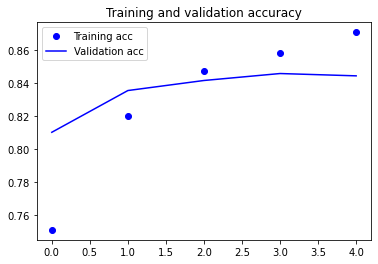

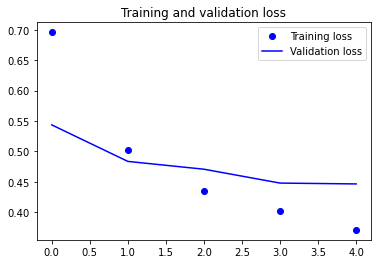

In [12]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
sample = "../input/cassava-leaf-disease-classification/sample_submission.csv"
sample_df = pd.read_csv(sample)
sample_df.head()

,image_id,label
0,2216849948.jpg,4


In [14]:
INPUT_PATH = "../input/cassava-leaf-disease-classification/"
test_images_path = INPUT_PATH+"test_images/"

In [15]:
import cv2
import tensorflow as tf
import numpy as np 
from matplotlib import pyplot as plt
from PIL import Image

In [16]:
predictions = []
for image_id in sample_df.image_id:
    img = Image.open(os.path.join(test_images_path+image_id))
    img = img.resize((224,224))
    img = np.expand_dims(img, axis=0)
    predictions.append(np.argmax(model.predict(img)))

sample_df["label"] = predictions
sample_df

,image_id,label
0,2216849948.jpg,4


In [17]:
sample_df.to_csv("submission.csv", index = False)